# **MULTI-CLASS SEGMENTATION OF BRAIN TUMOR CELLS USING U-NET MODELs (MANUALLY DEFINED VS PRE-TRAINED ENCODER)**

# Introduction to brian tumors

A brain tumor is an abnormal growth of cells within the brain or its surrounding structures, disrupting normal function. These tumors are classified as either benign (non-cancerous) or malignant (cancerous). While benign tumors grow slowly and rarely spread, they can still pose serious risks by compressing critical brain areas, impairing functions like movement, speech, or cognition. Malignant tumors, however, are aggressive and can invade nearby tissues or metastasize from other organs, such as the lungs or breasts, forming secondary metastatic brain tumors. Primary brain tumors, like gliomas or meningiomas, originate directly in the brain, with varying degrees of severity.

Symptoms often include persistent headaches, seizures, nausea, vision changes, balance issues, or personality shifts, depending on the tumor’s size and location. Diagnosis typically involves imaging techniques (MRI, CT scans) followed by a biopsy for confirmation. Treatment strategies—surgery, radiation, chemotherapy, or targeted therapies—are tailored to the tumor’s type, grade, and location. Prognosis varies widely; early detection and advances in medical research have improved outcomes, yet challenges remain, particularly for high-grade malignancies. Brain tumors underscore the complexity of neurological health, emphasizing the need for personalized care and ongoing scientific innovation to enhance survival and quality of life.gy.


# BraTS2020 Dataset Overview

**BraTS** (Brain Tumor Segmentation) is an annual challenge and dataset curated to advance automated segmentation of brain tumors using multi-modal MRI scans. The **2020 edition** focuses on gliomas, the most common primary brain malignancies.

---

## Key Features
- **Modalities**: Includes 4 MRI sequences per patient:
  - **Native (T1)**
  - **Post-contrast T1-weighted (T1Gd)**
  - **T2-weighted (T2)**
  - **T2 Fluid Attenuated Inversion Recovery (FLAIR)**
- **Annotations**: Manually segmented labels for tumor subregions:
  - **0 - Non-tumorous area**
  - **1 - Necrotic (Dead Tumor cells)**
  - **2 - Swollen tissue around tumor (Peritumoral Edema)**
  - **3 - Active tumor cells (Enhancing tumor)**
- **Data Size**:
  - **369 training cases** with ground truth labels.
  - **125 validation cases** (labels withheld for evaluation).
  - **166 testing cases** (used in the challenge).
- **Preprocessing**: Scans are co-registered, skull-stripped, and resampled to 1mm³ resolution.

---

## Dataset Structure
```plaintext
BraTS2020_TrainingData/
├── BraTS20_Training_001/
│   ├── BraTS20_Training_001_flair.nii
│   ├── BraTS20_Training_001_t1.nii
│   ├── BraTS20_Training_001_t1ce.nii
│   ├── BraTS20_Training_001_t2.nii
│   └── BraTS20_Training_001_seg.nii # Ground truth mask
...


# Import the Necessary Libraries

In [24]:
import os
import cv2
import random
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate, resize
from PIL import Image, ImageOps
import nibabel as nib
from pathlib import Path

#FastAI imports
import fastai
from fastai.vision.all import *  #A deep learning library based on PyTorch.
from tqdm import tqdm
from pdb import set_trace
from pprint import pprint

import wandb 
from fastai.callback.wandb import *

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import (
    CSVLogger, 
    ModelCheckpoint, 
    ReduceLROnPlateau, 
    EarlyStopping, 
    TensorBoard
)
from tensorflow.keras.layers import ( 
    RandomFlip,
    RandomRotation,
    RandomZoom,
    Rescaling,
    Conv2D, MaxPooling2D, Input, Dropout, UpSampling2D, concatenate
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
brats_path = "./brats2020/training_data/MICCAI_BraTS2020_TrainingData/"

In [8]:
# load .nii file as a numpy array and check its shape anf data type
test_image_flair = nib.load(brats_path + "BraTS20_Training_007/BraTS20_Training_007_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)
 
test_image_t1 = nib.load(brats_path + "BraTS20_Training_007/BraTS20_Training_007_t1.nii").get_fdata()   #t1 modality
test_image_t1ce = nib.load(brats_path + "BraTS20_Training_007/BraTS20_Training_007_t1ce.nii").get_fdata() #t1ce 
test_image_t2 = nib.load(brats_path + "BraTS20_Training_007/BraTS20_Training_007_t2.nii").get_fdata() #t2
test_image_seg = nib.load(brats_path + "BraTS20_Training_007/BraTS20_Training_007_seg.nii").get_fdata() #segmentation mask

Shape:  (240, 240, 155)
Dtype:  float64


Slice Number: 85


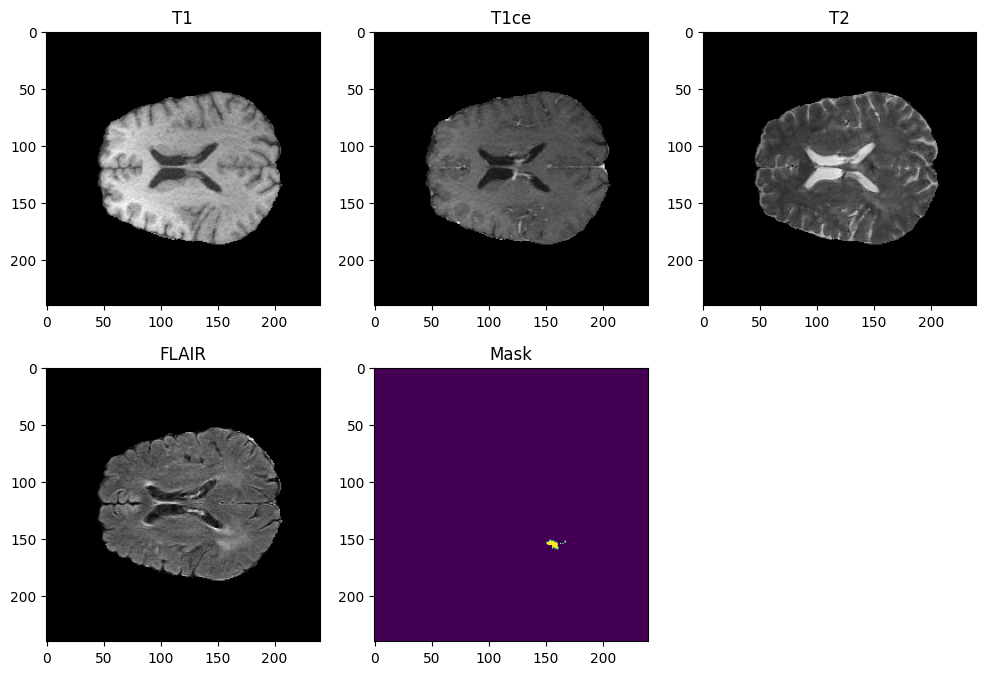

In [9]:
slice = 85

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

The four imaging modalities provide distinct perspectives on the same brain image, each highlighting different features.

**Detailed Description of Each Modality:**

1. **Native (T1):** This modality reveals the structure and composition of various tissue types in the brain. It's instrumental in identifying tumors, cysts, and other abnormalities.
2. **Post-contrast T1-weighted (T1ce, also known as T1Gd):** Similar to T1 images, but enhanced with a contrast agent (Gadolinium), which improves the visibility of abnormalities.
3. **T2-weighted (T2):** This modality highlights the fluid content within brain tissues.
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery):** This technique suppresses the fluid signals, making it easier to identify lesions that may not be visible on T1 or T2 images. It is particularly useful for detecting lesions in the brain's white matter, which are challenging to spot with other scans.

For medical experts, these four modalities collectively provide a comprehensive view, aiding in precise tumor analysis and confirmation. However, in our artificial intelligence approach, we aim to streamline the process by reducing computational and memory demands. Utilizing only two modalities can achieve this, making the segmentation task faster and more efficient.

To optimize our model, we will exclude the T1 modality since its enhanced counterpart, **T1ce**, provides better clarity. Similarly, we will omit the T2 modality because the fluids it highlights could negatively impact our predictions. Instead, the **T2-FLAIR** modality, which effectively highlights affected regions by suppressing fluid signals, will be more beneficial for our training.


Slice number: 55


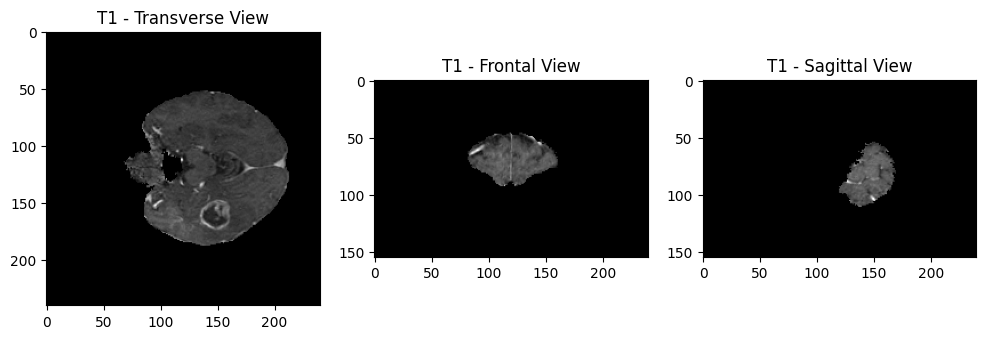

In [14]:
slice = 55

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

This visualization helps illustrate how each plane cuts through the brain and highlights different anatomical features, aiding in comprehensive analysis and segmentation.

Now, let's focus on the segmentations provided by the experts. These segmentations provide critical information about the tumor:

1. **Location:** Identifies the exact location of the tumor in the brain.
2. **Size and Shape:** Measures the tumor's dimensions and form.
3. **Type:** Helps differentiate between various tumor types.
4. **Heterogeneity:** Reveals different components within the tumor (e.g., solid tissue, necrotic areas).
5. **Surrounding Tissue Involvement:** Shows how the tumor interacts with adjacent brain structures.
6. **Cross-Modality Comparison:** Provides a comprehensive view by comparing different imaging modalities.

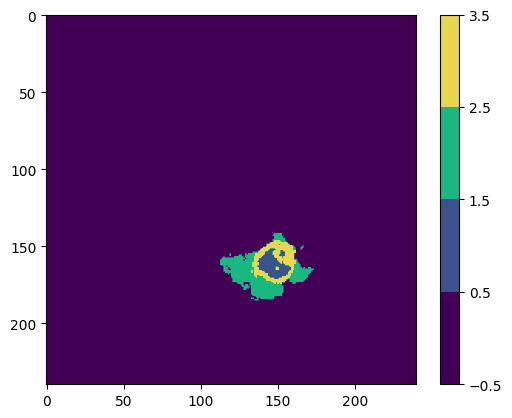

In [16]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,55], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

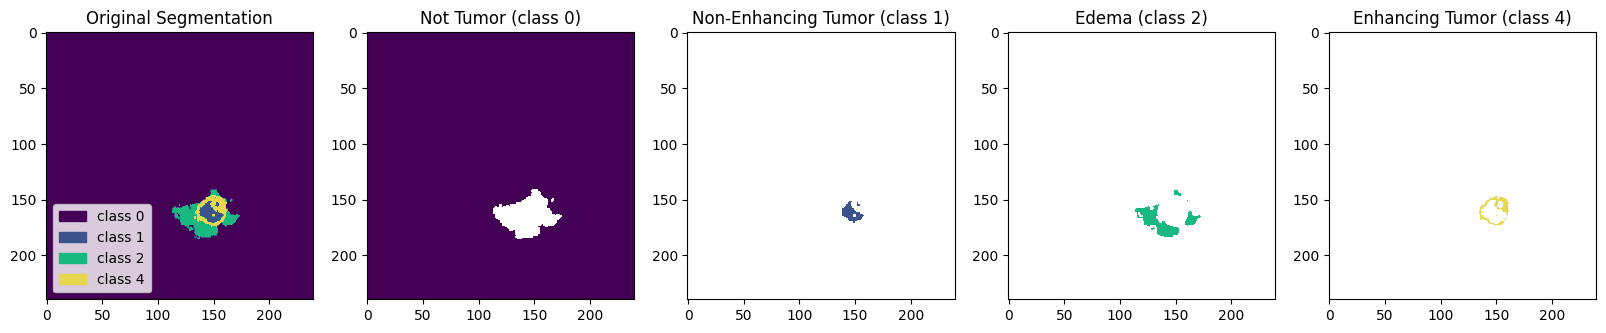

In [18]:
slice = 55

# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

These insights are essential for accurate diagnosis, treatment planning, and monitoring. The segmentations help visualize the tumor clearly, making it easier to understand its characteristics and interactions with surrounding tissues.

---

To summarize our data exploration:

- **Modalities:** Each sample/patient has 4 different modalities (T1, T1CE, T2, and FLAIR), accompanied by a segmentation indicating tumor areas.
- **Selected Modalities:** We will focus on T1CE and FLAIR as they provide complementary information about the brain's anatomy and tissue contrast.
- **3D Images:** Each image is 3D and can be analyzed through 3 different planes composed of 2D slices.
- **Informative Slices:** Many slices contain little or no information. We will use slices in the (50:-50) interval. You can customize this range, but note that changing it may affect training time.
- **Segmentation Classes:** Segmentation images contain 1 to 4 classes. Class 4 will be reassigned to 3 since class 3 is missing.
- **Background Class:** Class 0 (background) is over-represented. Cropping might remove important information, so we will keep the images as they are.

Now that we understand our data better, it's time to prepare for model training.

# **MODEL-1**

# **U-NET MODEL with XResNet34 PRETRAINED ENCODER**

### **Introduction to FASTAI**

#### FastAI is a deep learning library built on top of PyTorch that simplifies training and deploying state-of-the-art models. It is designed to enable both researchers and practitioners to rapidly prototype and train models with minimal boilerplate code.

#### FastAI is particularly useful for computer vision tasks like image classification, object detection, and semantic segmentation — including medical imaging applications such as brain tumor segmentation.

### **U-Net Architecture**
##### U-Net is a convolutional neural network architecture specifically designed for semantic segmentation tasks. It was originally proposed for biomedical image segmentation and has since become a standard model in the field due to its effectiveness and simplicity.

### Structure
##### Encoder (contracting path): Extracts features using successive convolution and pooling layers.
##### 
##### Decoder (expanding path): Reconstructs the segmentation map using upsampling and concatenation with corresponding encoder features (skip connections).

### Skip connections:
##### Preserve spatial information by directly connecting encoder layers to corresponding decoder layers.

##### U-Net is ideal for scenarios where localization and context are both important — such as medical image segmentation.

### **XResNet34 as Encoder**
##### XResNet34 is an enhanced version of the standard ResNet34. It includes modifications such as:
##### 
##### Removal of unnecessary batchnorm layers at the input.
##### 
##### More flexible stem layers for better performance on a variety of image resolutions.
##### 
##### Improved performance on smaller datasets or non-natural images (e.g., MRI scans).


### Creation of Flair, T1CE and mask slices

In [17]:
data_path = Path('./brats2020/training_data/MICCAI_BraTS2020_TrainingData') # I have stored this dataset in Azure DataLake Storage
Path.BASE_PATH = data_path

##### The function preprocess_patient_slices creates slice of flair, t1ce and segmentation masks slices ranging from 50 to 135 and saves in the folder

In [20]:
tmp_dir = Path('./slices')
tmp_img_dir = tmp_dir/'images'
tmp_mask_dir = tmp_dir/'masks'

def preprocess_patient_slices(patient_folder, img_list, mask_list):
    flair_path = next(patient_folder.glob(f"*{flair_suffix}"))
    t1ce_path = next(patient_folder.glob(f"*{t1ce_suffix}"))
    seg_path = next(patient_folder.glob(f"*{seg_suffix}"))

    flair_img = nib.load(str(flair_path)).get_fdata()
    t1ce_img = nib.load(str(t1ce_path)).get_fdata()

    seg_img = nib.load(str(seg_path)).get_fdata()

    scaler = MinMaxScaler()
    for i in slice_range:
        flair_slice = flair_img[:, :, i]
        seg_slice = seg_img[:, :, i]

        flair_norm = scaler.fit_transform(flair_slice)
        flair_img_pil = Image.fromarray((flair_norm * 255).astype(np.uint8)).resize((resize_dim, resize_dim))
        seg_img_pil = Image.fromarray(seg_slice.astype(np.uint8)).resize((resize_dim, resize_dim), resample=Image.NEAREST)

        img_name = f"{patient_folder.name}_slice{i}.png"
        mask_name = f"{patient_folder.name}_slice{i}_mask.png"

        flair_img_pil.save(tmp_img_dir/img_name)
        seg_img_pil.save(tmp_mask_dir/mask_name)

        img_list.append(tmp_img_dir/img_name)
        mask_list.append(tmp_mask_dir/mask_name)

#  Preprocessing all patients
tmp_dir.mkdir(exist_ok=True, parents=True)
(tmp_img_dir).mkdir(exist_ok=True, parents=True)
(tmp_mask_dir).mkdir(exist_ok=True, parents=True)

img_paths, mask_paths = [], []
for folder in data_path.iterdir():
    if folder.is_dir():
        preprocess_patient_slices(folder, img_paths, mask_paths)

##### Divide the training data into training and validation tests

In [21]:
#  Split
train_imgs, valid_imgs, train_masks, valid_masks = train_test_split(img_paths, mask_paths, test_size=0.2, random_state=42)

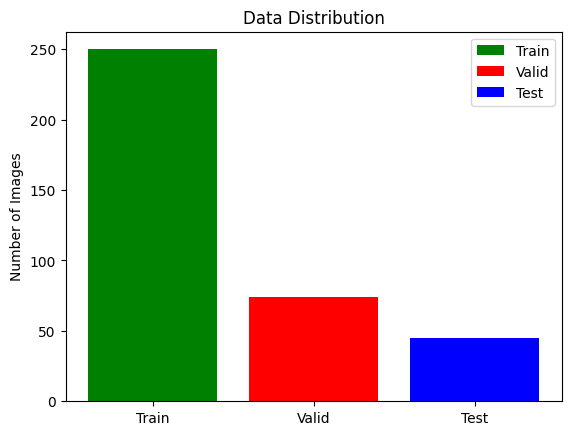

In [112]:
plt.bar(["Train","Valid"],
        [len(train_imgs), len(valid_masks)],
        align='center',
        color=[ 'orange','green'],
        label=["Train", "Valid"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

#### **Model Parameters**

In [25]:
BATCH_SIZE = 12
ARCHITECTURE = xresnet34
EPOCHS = 35
LR_MAX = 3e-4
ENCODER_FACTOR = 10
CODES = ['NOT TUMOR', 'NECROTIC', 'EDEMA', 'ENHANCING']

config_dictionary = dict(
    bs = BATCH_SIZE,
    architecture = str(ARCHITECTURE),
    epochs =EPOCHS,
    lr_max = LR_MAX,
    encoder_factor = ENCODER_FACTOR

)

#### **Data Augmentation**

In [6]:
tfms = [Dihedral(0.5),              # Horizontal and vertical flip
        Rotate(max_deg=180, p=0.9), # Rotation in any direction possible
        Brightness(0.2, p=0.75),
        Contrast(0.2),
        Saturation(0.2)]

In [7]:
# Set paths
data_path = Path('./brats2020/training_data/MICCAI_BraTS2020_TrainingData')
flair_suffix = "_flair.nii"
t1ce_suffix = "_t1ce.nii"
seg_suffix = "_seg.nii"
slice_range = range(50, 101)
resize_dim = 256



#### **Datablock and DataLoader**

##### FastAI provides a powerful and flexible DataBlock API to easily construct pipelines for any kind of data — including complex tasks like image segmentation. This abstraction separates the data processing pipeline into clear, reusable steps.

###### **What is a DataBlock?**
##### A DataBlock defines how to get your data, how to split it, how to label it, and what transforms to apply. It's a modular way to create your dataset.

###### **What are DataLoaders**?
##### Once a DataBlock is defined, you create DataLoaders (for training and validation) using .dataloaders():




In [23]:
def get_dls(train_imgs, valid_imgs, train_masks, valid_masks, bs=16):
    resize_dim = (256, 256)
    codes = np.array([0, 1, 2, 3]) 
    n_train = len(train_imgs)

    # Combining the image paths and corresponding mask paths
    items = list(zip(train_imgs + valid_imgs, train_masks + valid_masks))

    # Define label_func to fetch the corresponding mask for each image
    def label_func(x): return x[1] e

    # Splitter: Create an IndexSplitter for splitting the data
    splitter = IndexSplitter(list(range(n_train, len(items))))  # Splitting based on the first part being train and second being validation

    # Create the DataBlock
    dblock = DataBlock(
        blocks=(ImageBlock(), MaskBlock(codes=codes)),
        get_x=lambda x: x[0],  
        get_y=label_func,      
        splitter=splitter,
        item_tfms=Resize(resize_dim)  # Resize the images and masks
    )

    # Create DataLoader
    dls = dblock.dataloaders(items, bs=bs)

    return dls
dls = get_dls(train_imgs, valid_imgs, train_masks, valid_masks)

In [24]:
loss_func = CrossEntropyLossFlat(axis=1)

In [36]:
def show_batch(dl):
    for xb, yb in dl:
        print(f'Input shape: {xb.shape}')
        print(f'Label shape: {yb.shape}')
        break

show_batch(dls.train)


Input shape: torch.Size([16, 3, 256, 256])
Label shape: torch.Size([16, 256, 256])


In [31]:
class MyMixUp(MixUp):
    def before_batch(self):
        # Ensure that the labels are of type long
        self.yb = tuple(L(self.yb).map(lambda x: x.long() if x is not None else x))

#### **DEFINE THE MODEL**

#### The parameters of dataloader, encoder, optimizer, metrics and callbacks are passed into the model.

In [ ]:
learn = unet_learner(dls,                                 # DataLoaders containing (input) and (Output) 
                     ARCHITECTURE,                        # xResNet34
                     loss_func = loss_func,               # Weighted cross entropy loss
                     opt_func = Adam,                     # Adam optimizer
                     metrics = [Dice(), foreground_acc],  #  metrics
                     self_attention = False,
                     cbs = [SaveModelCallback(
                              monitor='dice',
                              comp=np.greater,
                              fname='best-model'
                            )]
                     )

In [33]:
learn.summary()

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/fastai/metrics.py:375: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


DynamicUnet (Input shape: 16 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

##### This is the full UNet model:

In [34]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
#collapse-output
learn.unfreeze()
learn.fit_one_cycle(
    EPOCHS,
    lr_max=slice(lr_max/ENCODER_FACTOR, lr_max),
    cbs=[WandbCallback()]
)

Epoch 1/35

250/250 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9789 - mean_io_u: 0.6160 - dice_coef: 0.2618 - precision: 0.9744 - sensitivity: 0.9551 - specificity: 0.9945 - dice_coef_necrotic: 0.0530 - dice_coef_edema: 0.1075 - dice_coef_enhancing: 0.0402

Epoch 1: val_loss improved from inf to 0.07497, saving model to model_.01-0.074967.m5

250/250 [==============================] - 249s 824ms/step - loss: 0.1785 - accuracy: 0.9789 - mean_io_u: 0.6160 - dice_coef: 0.2618 - precision: 0.9744 - sensitivity: 0.9551 - specificity: 0.9945 - dice_coef_necrotic: 0.0530 - dice_coef_edema: 0.1075 - dice_coef_enhancing: 0.0402 - val_loss: 0.0750 - val_accuracy: 0.9835 - val_mean_io_u: 0.3988 - val_dice_coef: 0.2668 - val_precision: 0.9834 - val_sensitivity: 0.9834 - val_specificity: 0.9945 - val_dice_coef_necrotic: 0.0443 - val_dice_coef_edema: 0.1085 - val_dice_coef_enhancing: 0.0472 - lr: 0.0010

Epoch 2/35

250/250 [==============================] - ETA: 0s - lo

#### Load the best model

In [26]:
learn.load('best-model');

##### **Predictions on the test set**

##### Predictions by PatientID

In [4]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [5]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [51]:
def showPredictsById(case, start_slice = 60):
    path = f"./brats2020/training_data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

4/4 [==============================] - 0s 45ms/step


<Figure size 1800x5000 with 0 Axes>

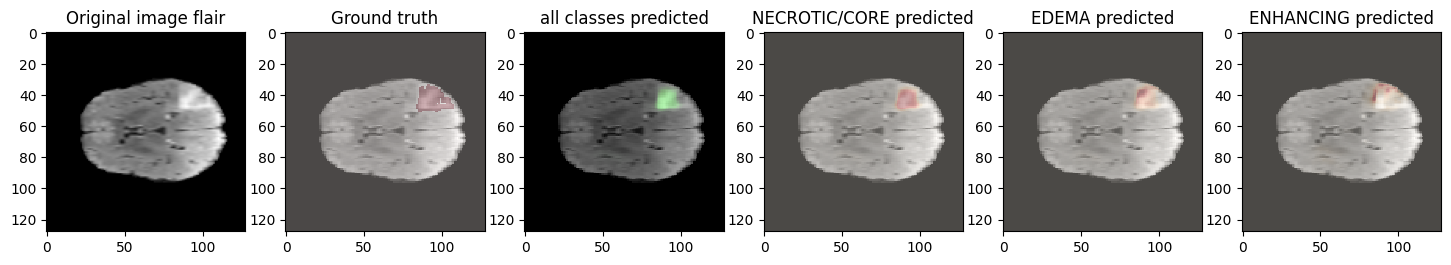

In [149]:
showPredictsById(case=test_ids[5][-3:])

4/4 [==============================] - 0s 65ms/step


<Figure size 1800x5000 with 0 Axes>

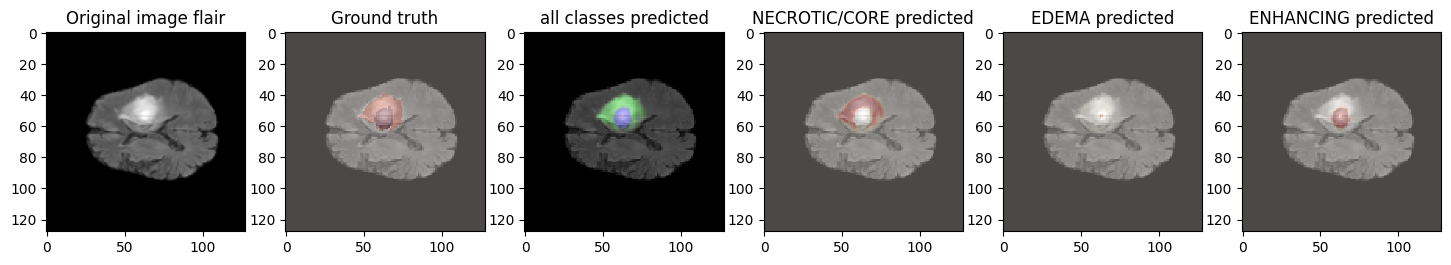

In [144]:
showPredictsById(case=test_ids[0][-3:])

##### Visualize the prediction mask by each class

In [7]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [8]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(brats_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

4/4 [==============================] - 0s 67ms/step

Patient number:  BraTS20_Training_173


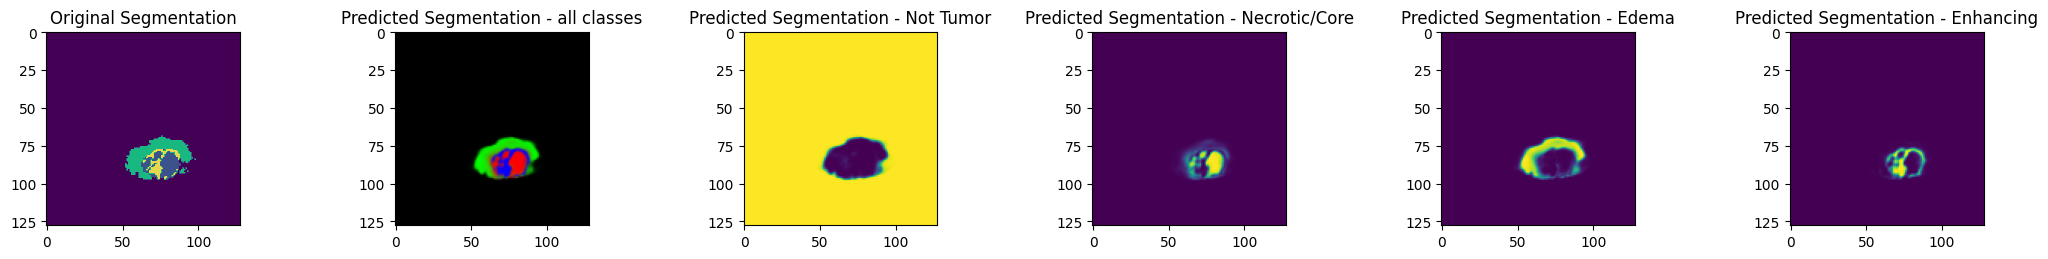

In [158]:
show_predicted_segmentations(test_ids, 60, cmap, norm)

4/4 [==============================] - 0s 63ms/step

Patient number:  BraTS20_Training_010


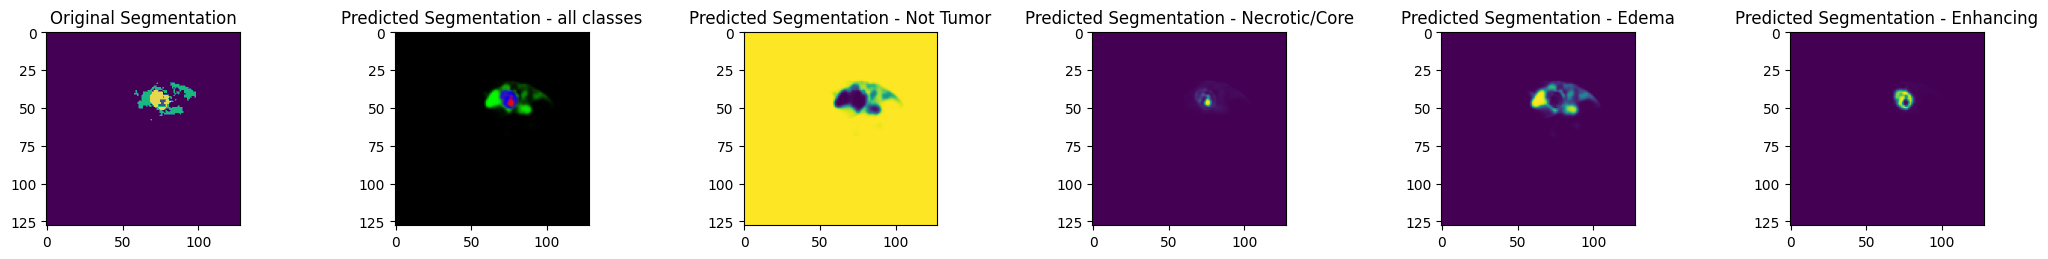

In [142]:
show_predicted_segmentations(test_ids, 65, cmap, norm)

#### **Evaluation** 

In [ ]:
# Evaluate the model on the test data
learn.compile(loss="categorical_crossentropy",
              optimizer= Adam(learning_rate=0.001),
              metrics = ['accuracy',dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

u_net_pretrained_results = learn.evaluate(test_gen, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

# Combine results list and descriptions list
results_list = zip(u_net_pretrained_results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 [==============================] - 14s 307ms/step - loss: 0.0267 - accuracy: 0.9931 - mean_io_u: 0.8426 - dice_coef: 0.6480 - precision: 0.9935 - sensitivity: 0.9916 - specificity: 0.9978 - dice_coef_necrotic: 0.5916 - dice_coef_edema: 0.7667 - dice_coef_enhancing: 0.7395



Model evaluation on the test set:


Loss : 0.0267

Accuracy : 0.9931

MeanIOU : 0.8426

Dice coefficient : 0.648

Precision : 0.9935

Sensitivity : 0.9916

Specificity : 0.9978

Dice coef Necrotic : 0.5916

Dice coef Edema : 0.7667

Dice coef Enhancing : 0.7395


# **MODEL-2**

# **U-NET MODEL WITH MANUALLY DEFINED ENCODER AND DECODER LAYERS**

## **TensorFlow Keras**
##### Keras is a high-level API integrated with TensorFlow, designed for building and training deep learning models with ease.
##### It supports both sequential and functional model architectures, making it flexible and user-friendly.
##### With TensorFlow backend, Keras enables efficient GPU acceleration and deployment across platforms.
##### It’s widely used in academia and industry for image, text, time-series, and custom ML tasks.

# Training and Validation sets

To train and evaluate our model effectively, we need to split our dataset into three parts: the training set (70-80%) for training the model, the validation set (10-15%) for tuning hyperparameters and preventing overfitting, and the test set (10-15%) for evaluating the final model's performance. We can use random splitting to divide the data or stratified splitting to maintain the same class distribution across sets, which is particularly useful for imbalanced datasets. Properly splitting the dataset ensures that our model is robust and performs well on unseen data.

In [9]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(brats_path) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

## **Preprocessing**

##### The following steps will be performed:
##### 
- ##### Path Retrieval: Load T1CE and FLAIR modalities (slices 50-135) along with corresponding segmentation masks.

- ##### Array Creation: Stack selected slices into X (2 channels: T1CE + FLAIR) and y (mask).

- ##### Class Fixing: Replace label 4 with 3 in y to fix missing class issues.

- ##### One-Hot Encoding: Convert y to one-hot format (classes 0–3) for compatibility with neural networks.
 
- ##### Additional Preprocessing:

- ##### Use axial slices for consistent 2D input (original shape: 240×240).

- ##### Resize images to 128×128 for memory efficiency and optimal CNN layer compatibility.

### **DataGenerator**



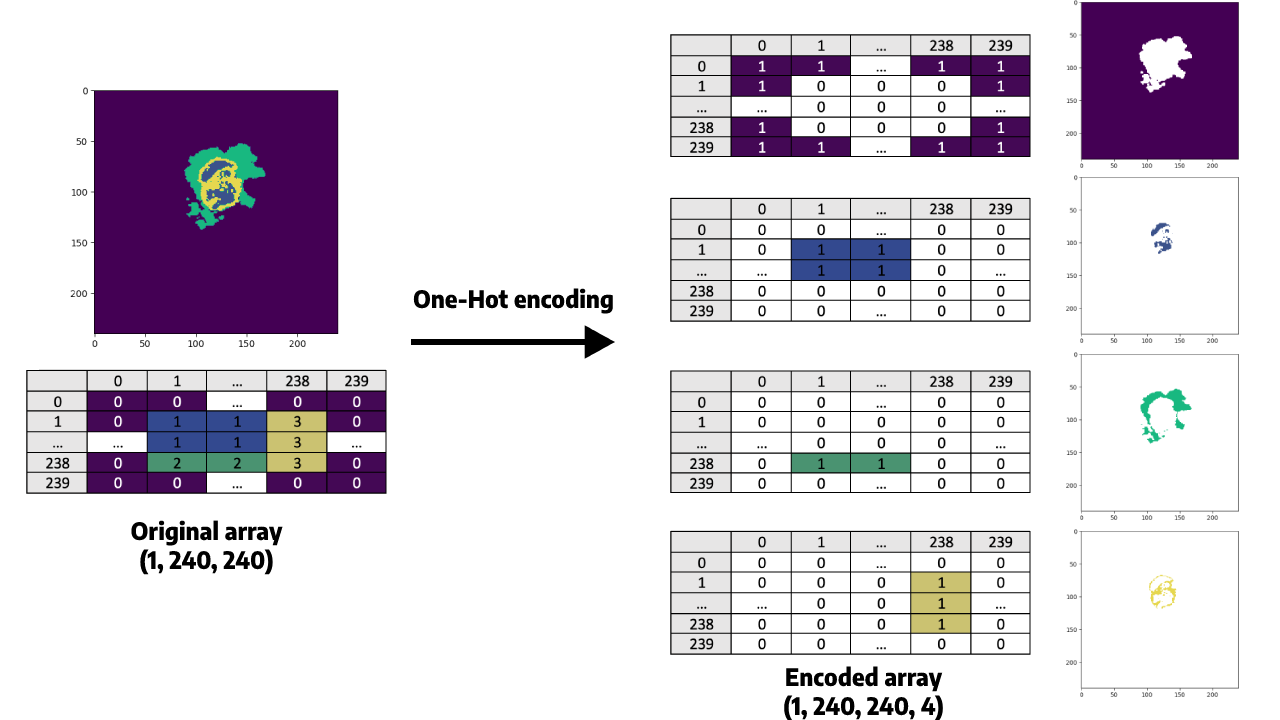

In [11]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 #
IMG_SIZE=128

In [12]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(brats_path, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

## **Cross-Entropy Loss and Dice Score**

##### **Cross Entropy** Loss is a commonly used loss function for multi-class classification tasks, including semantic segmentation. It works by comparing the predicted class probabilities for each pixel with the true class labels and penalizes the model more heavily when it is confidently wrong. This makes it effective for training models to output accurate pixel-wise predictions. Cross Entropy Loss is especially suitable when the class distribution is relatively balanced, although it can be adapted to handle imbalanced data by applying class weights.
##### 
##### **Dice Score**, on the other hand, is a similarity metric used to evaluate how well the predicted segmentation overlaps with the ground truth. It ranges from 0 to 1, where 1 indicates perfect overlap. Dice Score is particularly useful in medical image segmentation because it is more sensitive to class imbalance than standard accuracy. It focuses on the overlap between predicted and actual segments, making it ideal for measuring the quality of segmentation in scenarios where some classes may be underrepresented..


In [13]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [14]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

In [15]:
# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Define the U-NET Model

In [16]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

## Build and Plot the Model

In [25]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

## Set up callbacks

In [44]:
callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(
    filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

    ]

## Train and Save the Model

We are now ready to train our deep neural network using the `.fit()` method in Keras. We will pass our three callbacks to this method to be executed during the training process, which will last for 35 epochs.

In [45]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

Epoch 1/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8786 - dice_coef: 0.2306 - dice_coef_edema: 0.0476 - dice_coef_enhancing: 0.0152 - dice_coef_necrotic: 0.0212 - loss: 0.3952 - mean_io_u: 0.4751 - precision: 0.8773 - sensitivity: 0.8558 - specificity: 0.9863 
Epoch 1: val_loss improved from inf to 0.07508, saving model to model_.01-0.075077.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 536s 9s/step - accuracy: 0.8799 - dice_coef: 0.2310 - dice_coef_edema: 0.0482 - dice_coef_enhancing: 0.0154 - dice_coef_necrotic: 0.0213 - loss: 0.3920 - mean_io_u: 0.4762 - precision: 0.8786 - sensitivity: 0.8574 - specificity: 0.9864 - val_accuracy: 0.9872 - val_dice_coef: 0.2569 - val_dice_coef_edema: 0.1032 - val_dice_coef_enh

2025-04-18 03:23:50.037482: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-18 03:32:40.556113: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/anaconda/envs/azureml_py38/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need t

In [46]:
model.save("my_model.keras")

In [47]:
model = keras.models.load_model('./my_model.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

# Predict Tumor Segmentations

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


<Figure size 1800x5000 with 0 Axes>

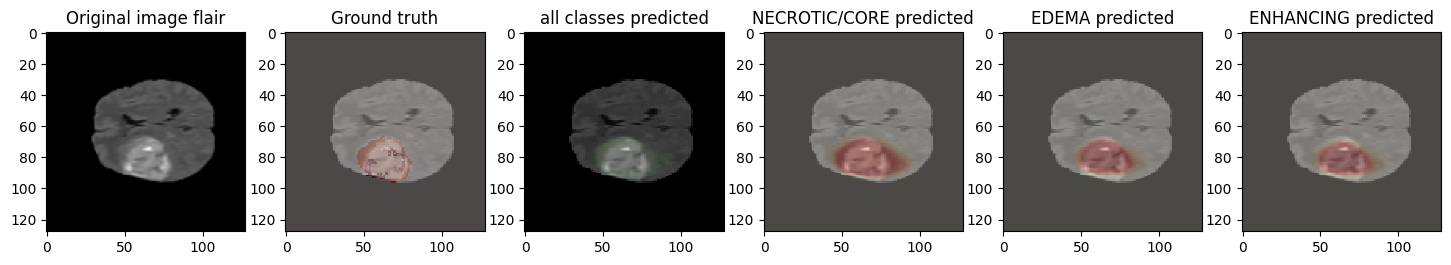

In [52]:
showPredictsById(case=test_ids[1][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step


<Figure size 1800x5000 with 0 Axes>

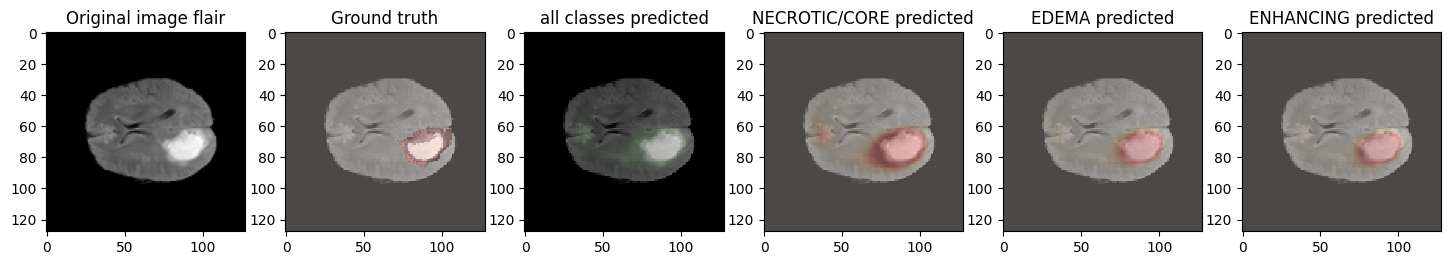

In [53]:
showPredictsById(case=test_ids[2][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step


<Figure size 1800x5000 with 0 Axes>

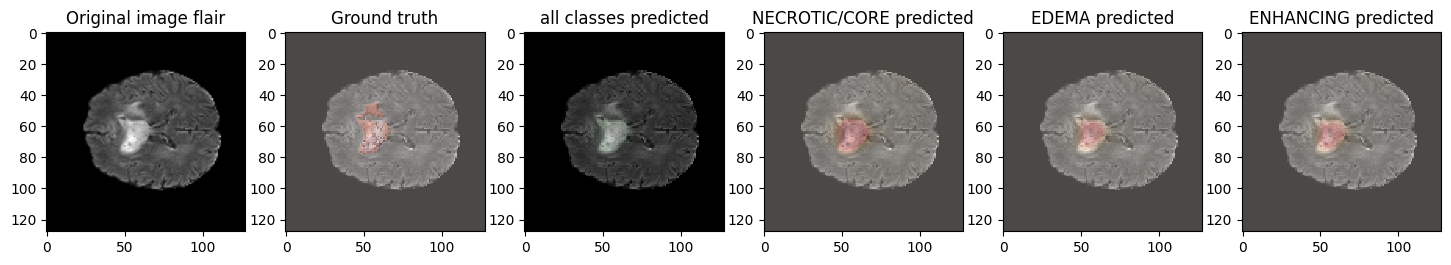

In [54]:
showPredictsById(case=test_ids[3][-3:])

In [59]:
from matplotlib.colors import BoundaryNorm
boundaries = [0, 1, 2, 3]
norm = BoundaryNorm(boundaries, ncolors=4)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 514ms/step
Patient number:  BraTS20_Training_095


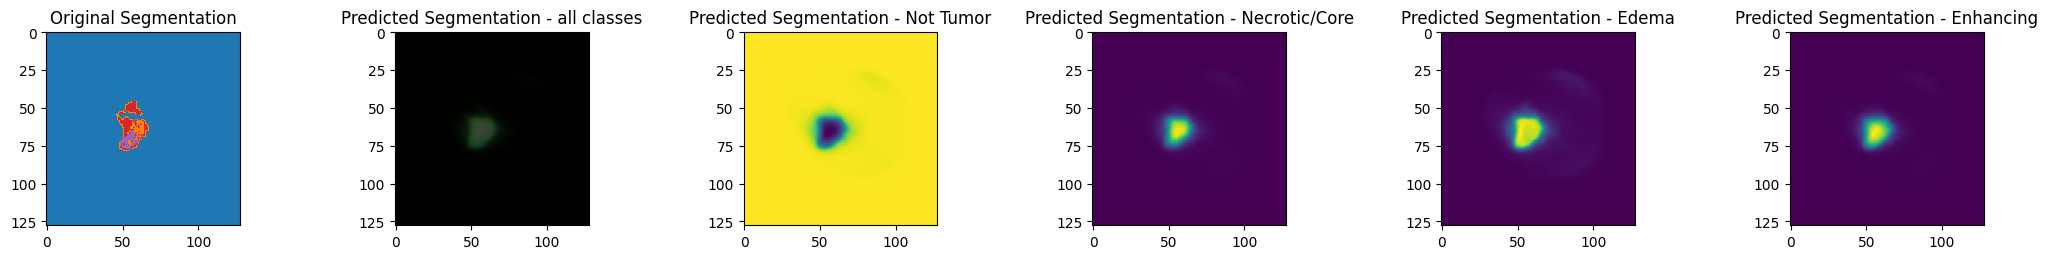

In [60]:
show_predicted_segmentations(test_ids, 60, 'tab10', norm)

### Evaluation

Let's call the `evaluate()` function to evaluate the performance of our model on our test dataset:

In [64]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9865 - dice_coef: 0.3696 - dice_coef_edema: 0.3095 - dice_coef_enhancing: 0.2797 - dice_coef_necrotic: 0.3445 - loss: 0.0353 - mean_io_u_2: 0.7733 - precision: 0.9948 - sensitivity: 0.9843 - specificity: 0.9981

Model evaluation on the test set:
Loss : 0.0368
Accuracy : 0.9859
MeanIOU : 0.7747
Dice coefficient : 0.3702
Precision : 0.9949
Sensitivity : 0.9828
Specificity : 0.9981
Dice coef Necrotic : 0.3321
Dice coef Edema : 0.3467
Dice coef Enhancing : 0.2598


### **Comparison of U-Net Architectures**

<table border="1" cellpadding="8" cellspacing="0">
  <thead>
    <tr>
      <th>Metric</th>
      <th>U-Net with Manual Encoder</th>
      <th>U-Net with XResNet34 Encoder</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Loss</strong></td>
      <td>0.0368</td>
      <td>0.0267</td>
    </tr>
    <tr>
      <td><strong>Accuracy</strong></td>
      <td>0.9859</td>
      <td>0.9931</td>
    </tr>
    <tr>
      <td><strong>Mean IoU</strong></td>
      <td>0.7747</td>
      <td>0.8426</td>
    </tr>
    <tr>
      <td><strong>Dice Coefficient</strong></td>
      <td>0.3702</td>
      <td>0.6480</td>
    </tr>
    <tr>
      <td><strong>Precision</strong></td>
      <td>0.9949</td>
      <td>0.9935</td>
    </tr>
    <tr>
      <td><strong>Sensitivity</strong></td>
      <td>0.9828</td>
      <td>0.9916</td>
    </tr>
    <tr>
      <td><strong>Specificity</strong></td>
      <td>0.9981</td>
      <td>0.9978</td>
    </tr>
    <tr>
      <td><strong>Dice Coef (Necrotic)</strong></td>
      <td>0.3321</td>
      <td>0.5916</td>
    </tr>
    <tr>
      <td><strong>Dice Coef (Edema)</strong></td>
      <td>0.3467</td>
      <td>0.7667</td>
    </tr>
    <tr>
      <td><strong>Dice Coef (Enhancing)</strong></td>
      <td>0.2598</td>
      <td>0.7395</td>
    </tr>
  </tbody>
</table>

### **Conclusion**
  ##### The <strong>U-Net with XResNet34 encoder</strong> consistently outperforms the manual encoder across nearly all metrics. It shows substantial improvements in <strong>Mean IoU</strong> and <strong>Dice Coefficient</strong>, particularly for tumor subtypes such as <strong>Edema</strong> and <strong>Enhancing tumor</strong>. Despite both models achieving high <strong>Precision</strong> and <strong>Specificity</strong>, the XResNet34-based model demonstrates superior <strong>generalization</strong> and <strong>segmentation quality</strong>, making it a more effective architecture for multi-class brain tumor segmentation.

